# Assignment 1: Social Data Analysis and Visualization

Group formed by Esben Kok, Sergi Lupon and Marta Arana

---
## **Assignment 1.1: Temporal Overview**

### ***Selection of the Personal Focus Crimes and creation of the merged dataset***

> #### *Draws from: Week 2*

All analyses in this assignment use the combined SF crime dataset built in Week 2.  
The merge process followed these steps:

1. **Two source tables** were combined:
   - Historical SFPD incidents (older schema)
   - Recent SFPD incidents (newer schema)

2. **Schema harmonization**:
   - Column names were standardized across both datasets (e.g., district, datetime, coordinates, category fields).
   - Data types were aligned so columns could be merged consistently.

3. **Unified time field**:
   - `incident_datetime` was parsed directly when available.
   - If missing in recent data, it was reconstructed from `incident_date` + `incident_time`.

4. **Crime category alignment**:
   - Categories were mapped into a common `personal_focus_crime` variable.
   - Ambiguous category changes across years were documented, including split/merge cases (e.g., historical `DRUG/NARCOTIC` vs recent `DRUG OFFENSE` + `DRUG VIOLATION`).

5. **Cross-dataset duplicate handling**:
   - Because IDs are not fully reliable across sources, duplicates were detected using a practical key:
     `incident_datetime (minute precision) + unified crime category + normalized police district`.
   - This was especially relevant around the 2018 overlap period.

6. **Final dataset for Assignment 1**:
   - We use the merged personal-focus dataset covering approximately **2003–2025**.
   - This means results depend on documented cleaning/mapping assumptions from Week 2.

In [12]:
### IMPORTS

import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# 1) Load both datasets 

base = Path.cwd()
recent_path = base / "files" / "Police_Department_Incident_Reports__2018_to_Present_20260204.csv"
hist_path   = base / "files" / "Police_Department_Incident_Reports__Historical_2003_to_May_2018_20260212.csv"
recent = pd.read_csv(recent_path, low_memory=False)
hist   = pd.read_csv(hist_path, low_memory=False)
# Normalize column names (same approach as Week1)
recent.columns = [c.strip().lower() for c in recent.columns]
hist.columns = [c.strip().lower() for c in hist.columns]

In [14]:
# 2) Map the column names of the two datasets to a common set of names.
import pandas as pd

column_mapping = pd.DataFrame({
    "Common name": [
        "row identifier",
        "incident id",
        "incident code",
        "crime type",
        "description",
        "police district",
        "date",
        "day of week",
        "time",
        "latitude",
        "longitude",
        "location",
        "address",
        "resolution",
        "data loaded at",
    ],
    "Historical column": [
        "pdid",
        "incidntnum",
        "incident code",
        "category",
        "descript",
        "pddistrict",
        "date",
        "dayofweek",
        "time",
        "y",
        "x",
        "location",
        "address",
        "resolution",
        "data_loaded_at",
    ],
    "Recent column": [
        "row id",
        "incident id",
        "incident code",
        "incident category",
        "incident description",
        "police district",
        "incident date",
        "incident day of week",
        "incident time",
        "latitude",
        "longitude",
        "point",
        "intersection",
        "resolution",
        "data_loaded_at",
    ],
})

column_mapping


,Common name,Historical column,Recent column
0,row identifier,pdid,row id
1,incident id,incidntnum,incident id
2,incident code,incident code,incident code
3,crime type,category,incident category
4,description,descript,incident description
5,police district,pddistrict,police district
6,date,date,incident date
7,day of week,dayofweek,incident day of week
8,time,time,incident time
9,latitude,y,latitude


In [15]:
# Build aligned dataframes with a shared scheme and delete columns that are not shared between the two datasets. This will make it easier to work with the data in the next steps.

hist_keep = [
    "pdid","incidntnum","incident code","category","descript","pddistrict",
    "date","dayofweek","time","y","x","location","address","resolution","data_loaded_at"
]
recent_keep = [
    "row id","incident id","incident code","incident category","incident description","police district",
    "incident date","incident day of week","incident time","latitude","longitude","point","intersection",
    "resolution","data_loaded_at","incident datetime", "incident year"
]

hist = hist[hist_keep].copy()
recent = recent[recent_keep].copy()

hist = hist.rename(columns={
    "pdid": "row identifier",
    "incidntnum": "incident id",
    "incident code": "incident code",
    "category": "category",
    "descript": "description",
    "pddistrict": "police district",
    "date": "date",
    "dayofweek": "day of week",
    "time": "time",
    "y": "latitude",
    "x": "longitude",
    "location": "point",
    "address": "address",
    "resolution": "resolution",
    "data_loaded_at": "data loaded at",
})

recent = recent.rename(columns={
    "row id": "row identifier",
    "incident id": "incident id",
    "incident code": "incident code",
    "incident category": "category",
    "incident description": "description",
    "police district": "police district",
    "incident date": "date",
    "incident day of week": "day of week",
    "incident time": "time",
    "latitude": "latitude",
    "longitude": "longitude",
    "point": "point",
    "intersection": "address",
    "resolution": "resolution",
    "data_loaded_at": "data loaded at",
    "incident datetime": "datetime",
    "incident year": "year"
})

In [16]:
# Ensure correct datetime formats and create missing datetime/year columns in the historical dataset

hist["date"] = pd.to_datetime(hist["date"], format="%m/%d/%Y", errors="coerce")
recent["date"] = pd.to_datetime(recent["date"], format="%Y/%m/%d", errors="coerce")

def normalize_hhmm(series):
    s = series.astype(str).str.strip()
    parts = s.str.extract(r"^\s*(\d{1,2}):(\d{2})(?::\d{2})?\s*$")
    hhmm = parts[0].str.zfill(2) + ":" + parts[1]
    return hhmm.where(parts[0].notna(), pd.NA)

hist["time"] = normalize_hhmm(hist["time"])
recent["time"] = normalize_hhmm(recent["time"])

# Historical: build datetime from date + time
recent["datetime"] = pd.to_datetime(
    recent["datetime"].astype(str).str.strip(),
    format="%Y/%m/%d %I:%M:%S %p",
    errors="coerce",
)

hist["datetime"] = pd.to_datetime(
    hist["date"].dt.strftime("%Y-%m-%d") + " " + hist["time"] + ":00",
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce",
)

hist["year"] = hist["date"].dt.year.astype("Int64")
recent["year"] = recent["date"].dt.year.astype("Int64")

hist["date"] = hist["date"].dt.date
recent["date"] = recent["date"].dt.date

In [17]:
hist_cat_raw = (
    hist["category"]
    .dropna()
    .astype(str)
    .str.strip()
    .loc[lambda s: s != ""]
    .drop_duplicates()
    .sort_values()
    .tolist()
)

recent_cat_raw = (
    recent["category"]
    .dropna()
    .astype(str)
    .str.strip()
    .loc[lambda s: s != ""]
    .drop_duplicates()
    .sort_values()
    .tolist()
)

hist_categories = sorted({c.upper() for c in hist_cat_raw})
recent_categories = sorted({c.upper() for c in recent_cat_raw})

hist_set = set(hist_categories)
recent_set = set(recent_categories)
direct_matches = sorted(hist_set & recent_set)

proposed_map = {
    "LARCENY/THEFT": ["LARCENY THEFT"],
    "VEHICLE THEFT": ["MOTOR VEHICLE THEFT", "MOTOR VEHICLE THEFT?"],
    "WARRANTS": ["WARRANT"],
    "DRUG/NARCOTIC": ["DRUG OFFENSE", "DRUG VIOLATION"],
    "FORGERY/COUNTERFEITING": ["FORGERY AND COUNTERFEITING"],
    "SUSPICIOUS OCC": ["SUSPICIOUS OCC", "SUSPICIOUS"],
    "WEAPON LAWS": ["WEAPONS OFFENSE", "WEAPONS OFFENCE", "WEAPONS CARRYING ETC"],
    "SEX OFFENSES, FORCIBLE": ["SEX OFFENSE", "RAPE"],
    "SEX OFFENSES, NON FORCIBLE": ["SEX OFFENSE"],
    "PROSTITUTION": ["PROSTITUTION", "HUMAN TRAFFICKING (A), COMMERCIAL SEX ACTS", "HUMAN TRAFFICKING, COMMERCIAL SEX ACTS"],
    "DRIVING UNDER THE INFLUENCE": ["TRAFFIC VIOLATION ARREST"],
    "VANDALISM": ["VANDALISM", "MALICIOUS MISCHIEF"],
    "DRUNKENNESS": ["DISORDERLY CONDUCT"]
}

validated_map = {
    h: [r for r in rs if r in recent_set]
    for h, rs in proposed_map.items()
    if h in hist_set
}
validated_map = {h: rs for h, rs in validated_map.items() if len(rs) > 0}

print("Historical categories (normalized):", len(hist_categories))
print("Recent categories (normalized):", len(recent_categories))
print("Direct matches:", len(direct_matches))
print("Proposed mapped historical categories:", len(validated_map))

print("\n=== Categories that appear to match ===")
for c in direct_matches:
    print(f"{c}  <->  {c}")
print("\n=== Categories that could match but need to be further analyzed ===")
for h, rs in sorted(validated_map.items()):
    print(f"{h}  <->  {'; '.join(rs)}")

Historical categories (normalized): 37
Recent categories (normalized): 49
Direct matches: 18
Proposed mapped historical categories: 13

=== Categories that appear to match ===
ARSON  <->  ARSON
ASSAULT  <->  ASSAULT
BURGLARY  <->  BURGLARY
DISORDERLY CONDUCT  <->  DISORDERLY CONDUCT
EMBEZZLEMENT  <->  EMBEZZLEMENT
FRAUD  <->  FRAUD
GAMBLING  <->  GAMBLING
LIQUOR LAWS  <->  LIQUOR LAWS
MISSING PERSON  <->  MISSING PERSON
NON-CRIMINAL  <->  NON-CRIMINAL
OTHER OFFENSES  <->  OTHER OFFENSES
PROSTITUTION  <->  PROSTITUTION
RECOVERED VEHICLE  <->  RECOVERED VEHICLE
ROBBERY  <->  ROBBERY
STOLEN PROPERTY  <->  STOLEN PROPERTY
SUICIDE  <->  SUICIDE
SUSPICIOUS OCC  <->  SUSPICIOUS OCC
VANDALISM  <->  VANDALISM

=== Categories that could match but need to be further analyzed ===
DRIVING UNDER THE INFLUENCE  <->  TRAFFIC VIOLATION ARREST
DRUG/NARCOTIC  <->  DRUG OFFENSE; DRUG VIOLATION
DRUNKENNESS  <->  DISORDERLY CONDUCT
FORGERY/COUNTERFEITING  <->  FORGERY AND COUNTERFEITING
LARCENY/THEFT  <->  

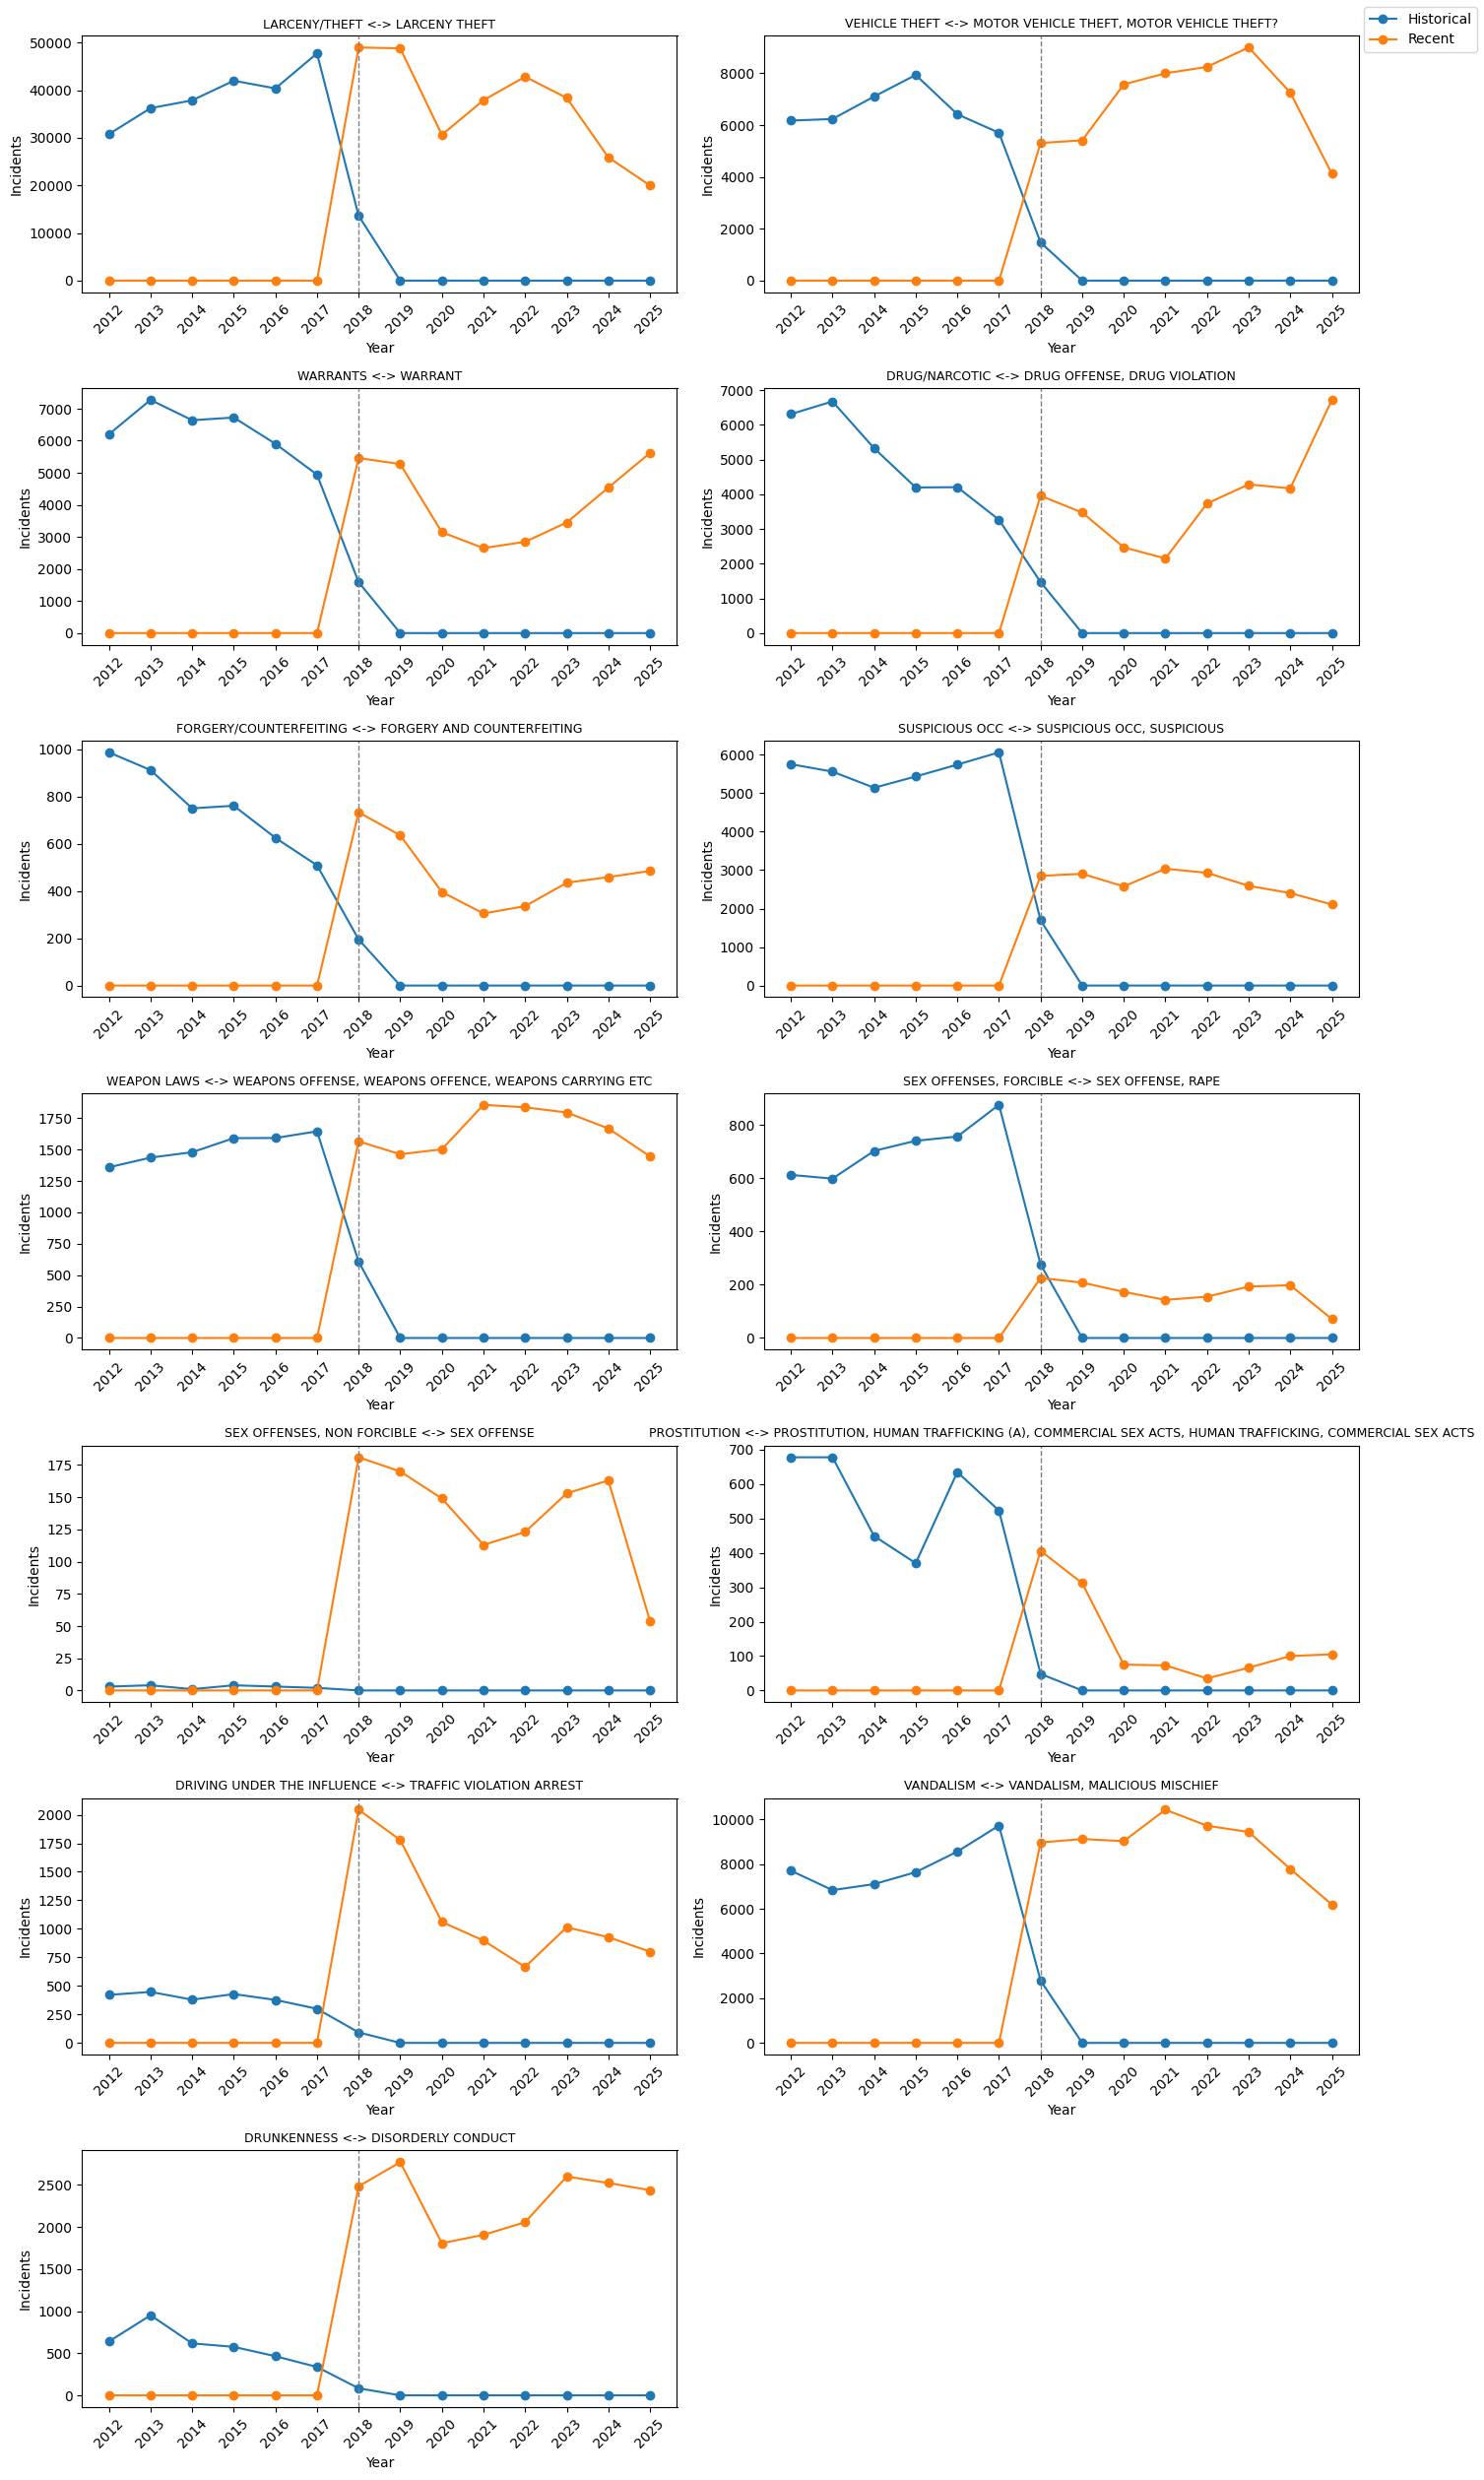

,historical_category,recent_categories,hist_mean_2015_2017,recent_mean_2019_2021,ratio_recent_over_hist
0,LARCENY/THEFT,LARCENY THEFT,43353.000000,39096.333333,0.901814
1,VEHICLE THEFT,"MOTOR VEHICLE THEFT, MOTOR VEHICLE THEFT?",6685.666667,6993.000000,1.045969
2,WARRANTS,WARRANT,5857.000000,3689.333333,0.629902
3,DRUG/NARCOTIC,"DRUG OFFENSE, DRUG VIOLATION",3887.000000,2696.666667,0.693766
4,FORGERY/COUNTERFEITING,FORGERY AND COUNTERFEITING,631.666667,445.666667,0.705541
5,SUSPICIOUS OCC,"SUSPICIOUS OCC, SUSPICIOUS",5747.333333,2840.000000,0.494142
6,WEAPON LAWS,"WEAPONS OFFENSE, WEAPONS OFFENCE, WEAPONS CARR...",1608.333333,1606.000000,0.998549
7,"SEX OFFENSES, FORCIBLE","SEX OFFENSE, RAPE",790.333333,174.666667,0.221004
8,"SEX OFFENSES, NON FORCIBLE",SEX OFFENSE,3.000000,144.000000,48.000000
9,PROSTITUTION,"PROSTITUTION, HUMAN TRAFFICKING (A), COMMERCIA...",509.333333,153.333333,0.301047


In [18]:
hist["category"] = hist["category"].astype(str).str.strip().str.upper()
recent["category"] = recent["category"].astype(str).str.strip().str.upper()

candidates = list(validated_map.items())

def validate_mapping_subplot(hist_cat, recent_cats, ax, year_min=2012, year_max=2025):
    years = pd.Index(range(year_min, year_max + 1), name="year")

    hist_series = (
        hist.loc[hist["category"] == hist_cat]
        .groupby("year")
        .size()
        .reindex(years, fill_value=0)
    )

    recent_series = (
        recent.loc[recent["category"].isin(recent_cats)]
        .groupby("year")
        .size()
        .reindex(years, fill_value=0)
    )

    ax.plot(hist_series.index, hist_series.values, marker="o", label="Historical")
    ax.plot(recent_series.index, recent_series.values, marker="o", label="Recent")
    ax.axvline(2018, linestyle="--", color="gray", linewidth=1)
    ax.set_title(f"{hist_cat} <-> {', '.join(recent_cats)}", fontsize=9)
    ax.set_ylabel("Incidents")
    ax.axis("tight")

    hist_ref = hist_series.loc[(hist_series.index >= 2015) & (hist_series.index <= 2017)].mean()
    recent_ref = recent_series.loc[(recent_series.index >= 2019) & (recent_series.index <= 2021)].mean()
    ratio_recent_over_hist = np.nan if hist_ref == 0 else recent_ref / hist_ref

    return {
        "historical_category": hist_cat,
        "recent_categories": ", ".join(recent_cats),
        "hist_mean_2015_2017": hist_ref,
        "recent_mean_2019_2021": recent_ref,
        "ratio_recent_over_hist": ratio_recent_over_hist
    }

n = len(candidates)
ncols = 2
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3.6 * nrows), sharex=True, sharey=False)
axes = np.array(axes).reshape(-1)

evidence_rows = []
for i, (hist_cat, recent_cats) in enumerate(candidates):
    evidence_rows.append(validate_mapping_subplot(hist_cat, recent_cats, axes[i]))

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Year labels on every subplot
for ax in axes[:n]:
    ax.set_xlabel("Year")
    ax.set_xticks(range(2012, 2026))
    ax.set_xticklabels([str(y) for y in range(2012, 2026)], rotation=45)
    ax.tick_params(axis="x", labelbottom=True)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout()
plt.show()

evidence_24 = pd.DataFrame(evidence_rows)
evidence_24


To validate each doubtful mapping, we compared yearly incident counts before and after the 2018 schema transition and checked both:
- **trend continuity** in the plots around 2018, and  
- **scale consistency** using `ratio_recent_over_hist` (mean 2019–2021 / mean 2015–2017).

---

### Accepted (kept)

- **`LARCENY/THEFT` -> `LARCENY THEFT`** (`ratio = 0.90`)  
  Strong semantic equivalence and good continuity in scale/trend.

- **`VEHICLE THEFT` -> `MOTOR VEHICLE THEFT`, `MOTOR VEHICLE THEFT?`** (`ratio = 1.05`)  
  Very plausible rename/split handling; levels are highly consistent across transition.

- **`WARRANTS` -> `WARRANT`** (`ratio = 0.63`)  
  Conceptually close and trend shape remains comparable, though recent levels are lower.

- **`DRUG/NARCOTIC` -> `DRUG OFFENSE`, `DRUG VIOLATION`** (`ratio = 0.69`)  
  Plausible split/merge; trend is compatible with classification update despite lower post-2018 level.

- **`FORGERY/COUNTERFEITING` -> `FORGERY AND COUNTERFEITING`** (`ratio = 0.71`)  
  Clear semantic match; trend and magnitudes are reasonably aligned.

- **`WEAPON LAWS` -> `WEAPONS OFFENSE`, `WEAPONS OFFENCE`, `WEAPONS CARRYING ETC`** (`ratio = 1.00`)  
  Best continuity case: near one-to-one scale and similar evolution.

- **`VANDALISM` -> `VANDALISM`, `MALICIOUS MISCHIEF`** (`ratio = 1.10`)  
  Strong practical continuity and defensible semantic overlap.

---

### Rejected (not kept)

- **`SUSPICIOUS OCC` -> `SUSPICIOUS OCC`, `SUSPICIOUS`** (`ratio = 0.49`)  
  Category is too broad/reporting-sensitive; post-2018 level shift is large for a strict mapping.

- **`SEX OFFENSES, FORCIBLE` -> `SEX OFFENSE`, `RAPE`** (`ratio = 0.22`)  
  Weak continuity; likely major reclassification rather than stable one-to-one correspondence.

- **`SEX OFFENSES, NON FORCIBLE` -> `SEX OFFENSE`** (`ratio = 48.00`)  
  Historical baseline is tiny; ratio is unstable and not credible for equivalence.

- **`PROSTITUTION` -> `PROSTITUTION`, `HUMAN TRAFFICKING (A), COMMERCIAL SEX ACTS`, `HUMAN TRAFFICKING, COMMERCIAL SEX ACTS`** (`ratio = 0.30`)  
  Adding trafficking categories does not recover continuity; keep trafficking separate.

- **`DRIVING UNDER THE INFLUENCE` -> `TRAFFIC VIOLATION ARREST`** (`ratio = 3.38`)  
  Recent side is too broad; mismatch in definition and scale.

- **`DRUNKENNESS` -> `DISORDERLY CONDUCT`** (`ratio = 4.70`)  
  Conceptual mismatch and strong scale break indicate non-equivalence.

---

### Final interpretation

The strict mapping keeps pairs with defensible semantic equivalence and acceptable trend continuity around 2018.  
Low-confidence or policy/reporting-sensitive mappings were rejected to preserve downstream analysis quality.

In [19]:
# Build a curated focus table from direct + validated/rejected ambiguous mappings

# 1) Direct same-name matches -> High confidence
direct_rows = [
    ("ARSON", "ARSON", ["ARSON"], "High", "Direct match"),
    ("ASSAULT", "ASSAULT", ["ASSAULT"], "High", "Direct match"),
    ("BURGLARY", "BURGLARY", ["BURGLARY"], "High", "Direct match"),
    ("DISORDERLY CONDUCT", "DISORDERLY CONDUCT", ["DISORDERLY CONDUCT"], "High", "Direct match"),
    ("EMBEZZLEMENT", "EMBEZZLEMENT", ["EMBEZZLEMENT"], "High", "Direct match"),
    ("FRAUD", "FRAUD", ["FRAUD"], "High", "Direct match"),
    ("GAMBLING", "GAMBLING", ["GAMBLING"], "High", "Direct match"),
    ("LIQUOR LAWS", "LIQUOR LAWS", ["LIQUOR LAWS"], "High", "Direct match"),
    ("MISSING PERSON", "MISSING PERSON", ["MISSING PERSON"], "High", "Direct match"),
    ("NON-CRIMINAL", "NON-CRIMINAL", ["NON-CRIMINAL"], "High", "Direct match"),
    ("OTHER OFFENSES", "OTHER OFFENSES", ["OTHER OFFENSES"], "High", "Direct match"),
    ("RECOVERED VEHICLE", "RECOVERED VEHICLE", ["RECOVERED VEHICLE"], "High", "Direct match"),
    ("ROBBERY", "ROBBERY", ["ROBBERY"], "High", "Direct match"),
    ("STOLEN PROPERTY", "STOLEN PROPERTY", ["STOLEN PROPERTY"], "High", "Direct match"),
    ("SUICIDE", "SUICIDE", ["SUICIDE"], "High", "Direct match"),
]

# 2) Ambiguous mappings accepted after Step 2.4
accepted_rows = [
    ("DRUG/NARCOTIC", "DRUG/NARCOTIC", ["DRUG OFFENSE", "DRUG VIOLATION"], "Medium", "Validated with plotting (trend, ratio)"),
    ("FORGERY/COUNTERFEITING", "FORGERY/COUNTERFEITING", ["FORGERY AND COUNTERFEITING"], "Medium-High", "Slight change of name"),
    ("LARCENY/THEFT", "LARCENY/THEFT", ["LARCENY THEFT"], "Medium-High", "Slight change of name"),
    ("SUSPICIOUS OCC", "SUSPICIOUS OCC", ["SUSPICIOUS OCC", "SUSPICIOUS"], "Low-Medium", "Validated with plotting (trend, ratio)"),
    ("VANDALISM", "VANDALISM", ["VANDALISM", "MALICIOUS MISCHIEF"], "Medium", "Validated with plotting (trend, ratio)"),
    ("VEHICLE THEFT", "VEHICLE THEFT", ["MOTOR VEHICLE THEFT", "MOTOR VEHICLE THEFT?"], "Medium-High", "Slight change of name"),
    ("WARRANTS", "WARRANTS", ["WARRANT"], "Medium-High", "Slight change of name"),
    ("WEAPON LAWS", "WEAPON LAWS", ["WEAPONS OFFENSE", "WEAPONS OFFENCE", "WEAPONS CARRYING ETC"], "Medium-High", "Validated with plotting (trend, ratio)"),
]

# 3) Discarded mappings
include_low = True
low_rows = [
    ("SEX OFFENSES, FORCIBLE", "SEX OFFENSES, FORCIBLE", ["SEX OFFENSE", "RAPE"], "Low", "Rejected by plotting (trend, ratio)"),
    ("SEX OFFENSES, NON FORCIBLE", "SEX OFFENSES, NON FORCIBLE", ["SEX OFFENSE"], "Low", "Rejected by plotting (trend, ratio)"),
    ("DRIVING UNDER THE INFLUENCE", "DRIVING UNDER THE INFLUENCE", ["TRAFFIC VIOLATION ARREST"], "Low", "Rejected by plotting (trend, ratio)"),
    ("DRUNKENNESS", "DRUNKENNESS", ["DISORDERLY CONDUCT"], "Low", "Rejected by plotting (trend, ratio)"),
    ("PROSTITUTION", "PROSTITUTION", ["PROSTITUTION", "HUMAN TRAFFICKING (A), COMMERCIAL SEX ACTS", "HUMAN TRAFFICKING, COMMERCIAL SEX ACTS"], "Low", "Rejected by plotting (trend, ratio)"),
]

rows = direct_rows + accepted_rows + (low_rows if include_low else [])

focus_df = pd.DataFrame(
    rows,
    columns=["Personal Focus Crime", "Historical", "Recent", "Confidence", "Notes"]
)

focus_df["Recent"] = focus_df["Recent"].apply(lambda x: ", ".join(x))
focus_df

,Personal Focus Crime,Historical,Recent,Confidence,Notes
0,ARSON,ARSON,ARSON,High,Direct match
1,ASSAULT,ASSAULT,ASSAULT,High,Direct match
2,BURGLARY,BURGLARY,BURGLARY,High,Direct match
3,DISORDERLY CONDUCT,DISORDERLY CONDUCT,DISORDERLY CONDUCT,High,Direct match
4,EMBEZZLEMENT,EMBEZZLEMENT,EMBEZZLEMENT,High,Direct match
5,FRAUD,FRAUD,FRAUD,High,Direct match
6,GAMBLING,GAMBLING,GAMBLING,High,Direct match
7,LIQUOR LAWS,LIQUOR LAWS,LIQUOR LAWS,High,Direct match
8,MISSING PERSON,MISSING PERSON,MISSING PERSON,High,Direct match
9,NON-CRIMINAL,NON-CRIMINAL,NON-CRIMINAL,High,Direct match


At this stage, we will **temporarily select as Personal Focus crimes** all categories in the mapping table with confidence levels **High, Medium-High, and Medium**; therefore, we will not consider incidents from other categories.

From the table above, we'll proceed to edit both datasets in order to change the names to the established one within the "Personal Focus Crime" column above, according to the agreed matches

In [20]:
# 1) Keep only Medium / Medium-High / High rows
focus_keep = focus_df[focus_df["Confidence"].isin(["Medium", "Medium-High", "High"])].copy()

# 2) Build rename maps from selected rows
hist_map = dict(zip(focus_keep["Historical"], focus_keep["Personal Focus Crime"]))

recent_map = {}
for _, row in focus_keep.iterrows():
    target = row["Personal Focus Crime"]
    for r in row["Recent"].split(","):
        recent_map[r.strip()] = target

# 3) Rename categories in both dataframes
hist["category"] = hist["category"].replace(hist_map)
recent["category"] = recent["category"].replace(recent_map)

# 4) Keep only selected Personal Focus Crime categories
selected_focus = set(focus_keep["Personal Focus Crime"])

hist = hist[hist["category"].isin(selected_focus)].copy()
recent = recent[recent["category"].isin(selected_focus)].copy()

### Merge historical + recent and remove 2018 cross-dataset duplicates

We merge the two focus datasets into one final table (`merged`).  
Before concatenation, we remove **only** rows from the recent dataset that duplicate historical records using the group rule:

- same `incident_datetime`,
- same `personal_focus_crime` (category),
- same `police_district`.

This targets overlap around the 2018 transition while preserving all non-overlapping rows.

In [21]:
# Standardize district text (as agreed)
hist["police district"] = hist["police district"].astype(str).str.strip().str.upper()
recent["police district"] = recent["police district"].astype(str).str.strip().str.upper()

# Duplicate rule across datasets
keys = ["datetime", "category", "police district"]

# Keys from historical dataset
hist_keys = hist[keys].dropna().drop_duplicates()

# Delete non-complete years (2026 year)
recent = recent[recent["year"] != 2026].copy()

# Keep only recent rows whose key is NOT in historical
recent_deduplicated = (
    recent
    .merge(hist_keys, on=keys, how="left", indicator=True)
    .loc[lambda d: d["_merge"] == "left_only"]
    .drop(columns="_merge")
)

# Final merged dataframe
merged = pd.concat([hist, recent_deduplicated], ignore_index=True)

# Counts
print("Rows in recent (before):", len(recent))
print("Rows in recent_deduplicated (after):", len(recent_deduplicated))
print("Rows removed from recent:", len(recent) - len(recent_deduplicated))
print("Rows in hist:", len(hist))
print("Rows in merged:", len(merged))

Rows in recent (before): 814070
Rows in recent_deduplicated (after): 787462
Rows removed from recent: 26608
Rows in hist: 1901170
Rows in merged: 2688632


The goal is to run a final consistency check: we will plot these selected matches again as **evolutionary time series** to verify whether the historical and recent definitions still behave as comparable categories over time.  This is important because even when names are identical, category logic may have changed (e.g., re-labeling, split/merge into multiple groups, or shifts in reporting/classification practice), and we haven't verified those in the previous subplots.

In parallel, we will **exclude**:
- crime types that are too generic or not analytically useful for this focus (e.g., `OTHER OFFENSES`, `NON-CRIMINAL`, `DISORDERLY CONDUCT`);
- categories that still show clearly non-matching trends after validation;
- very rare/low-volume categories, especially those less relevant to the current analytical objective.

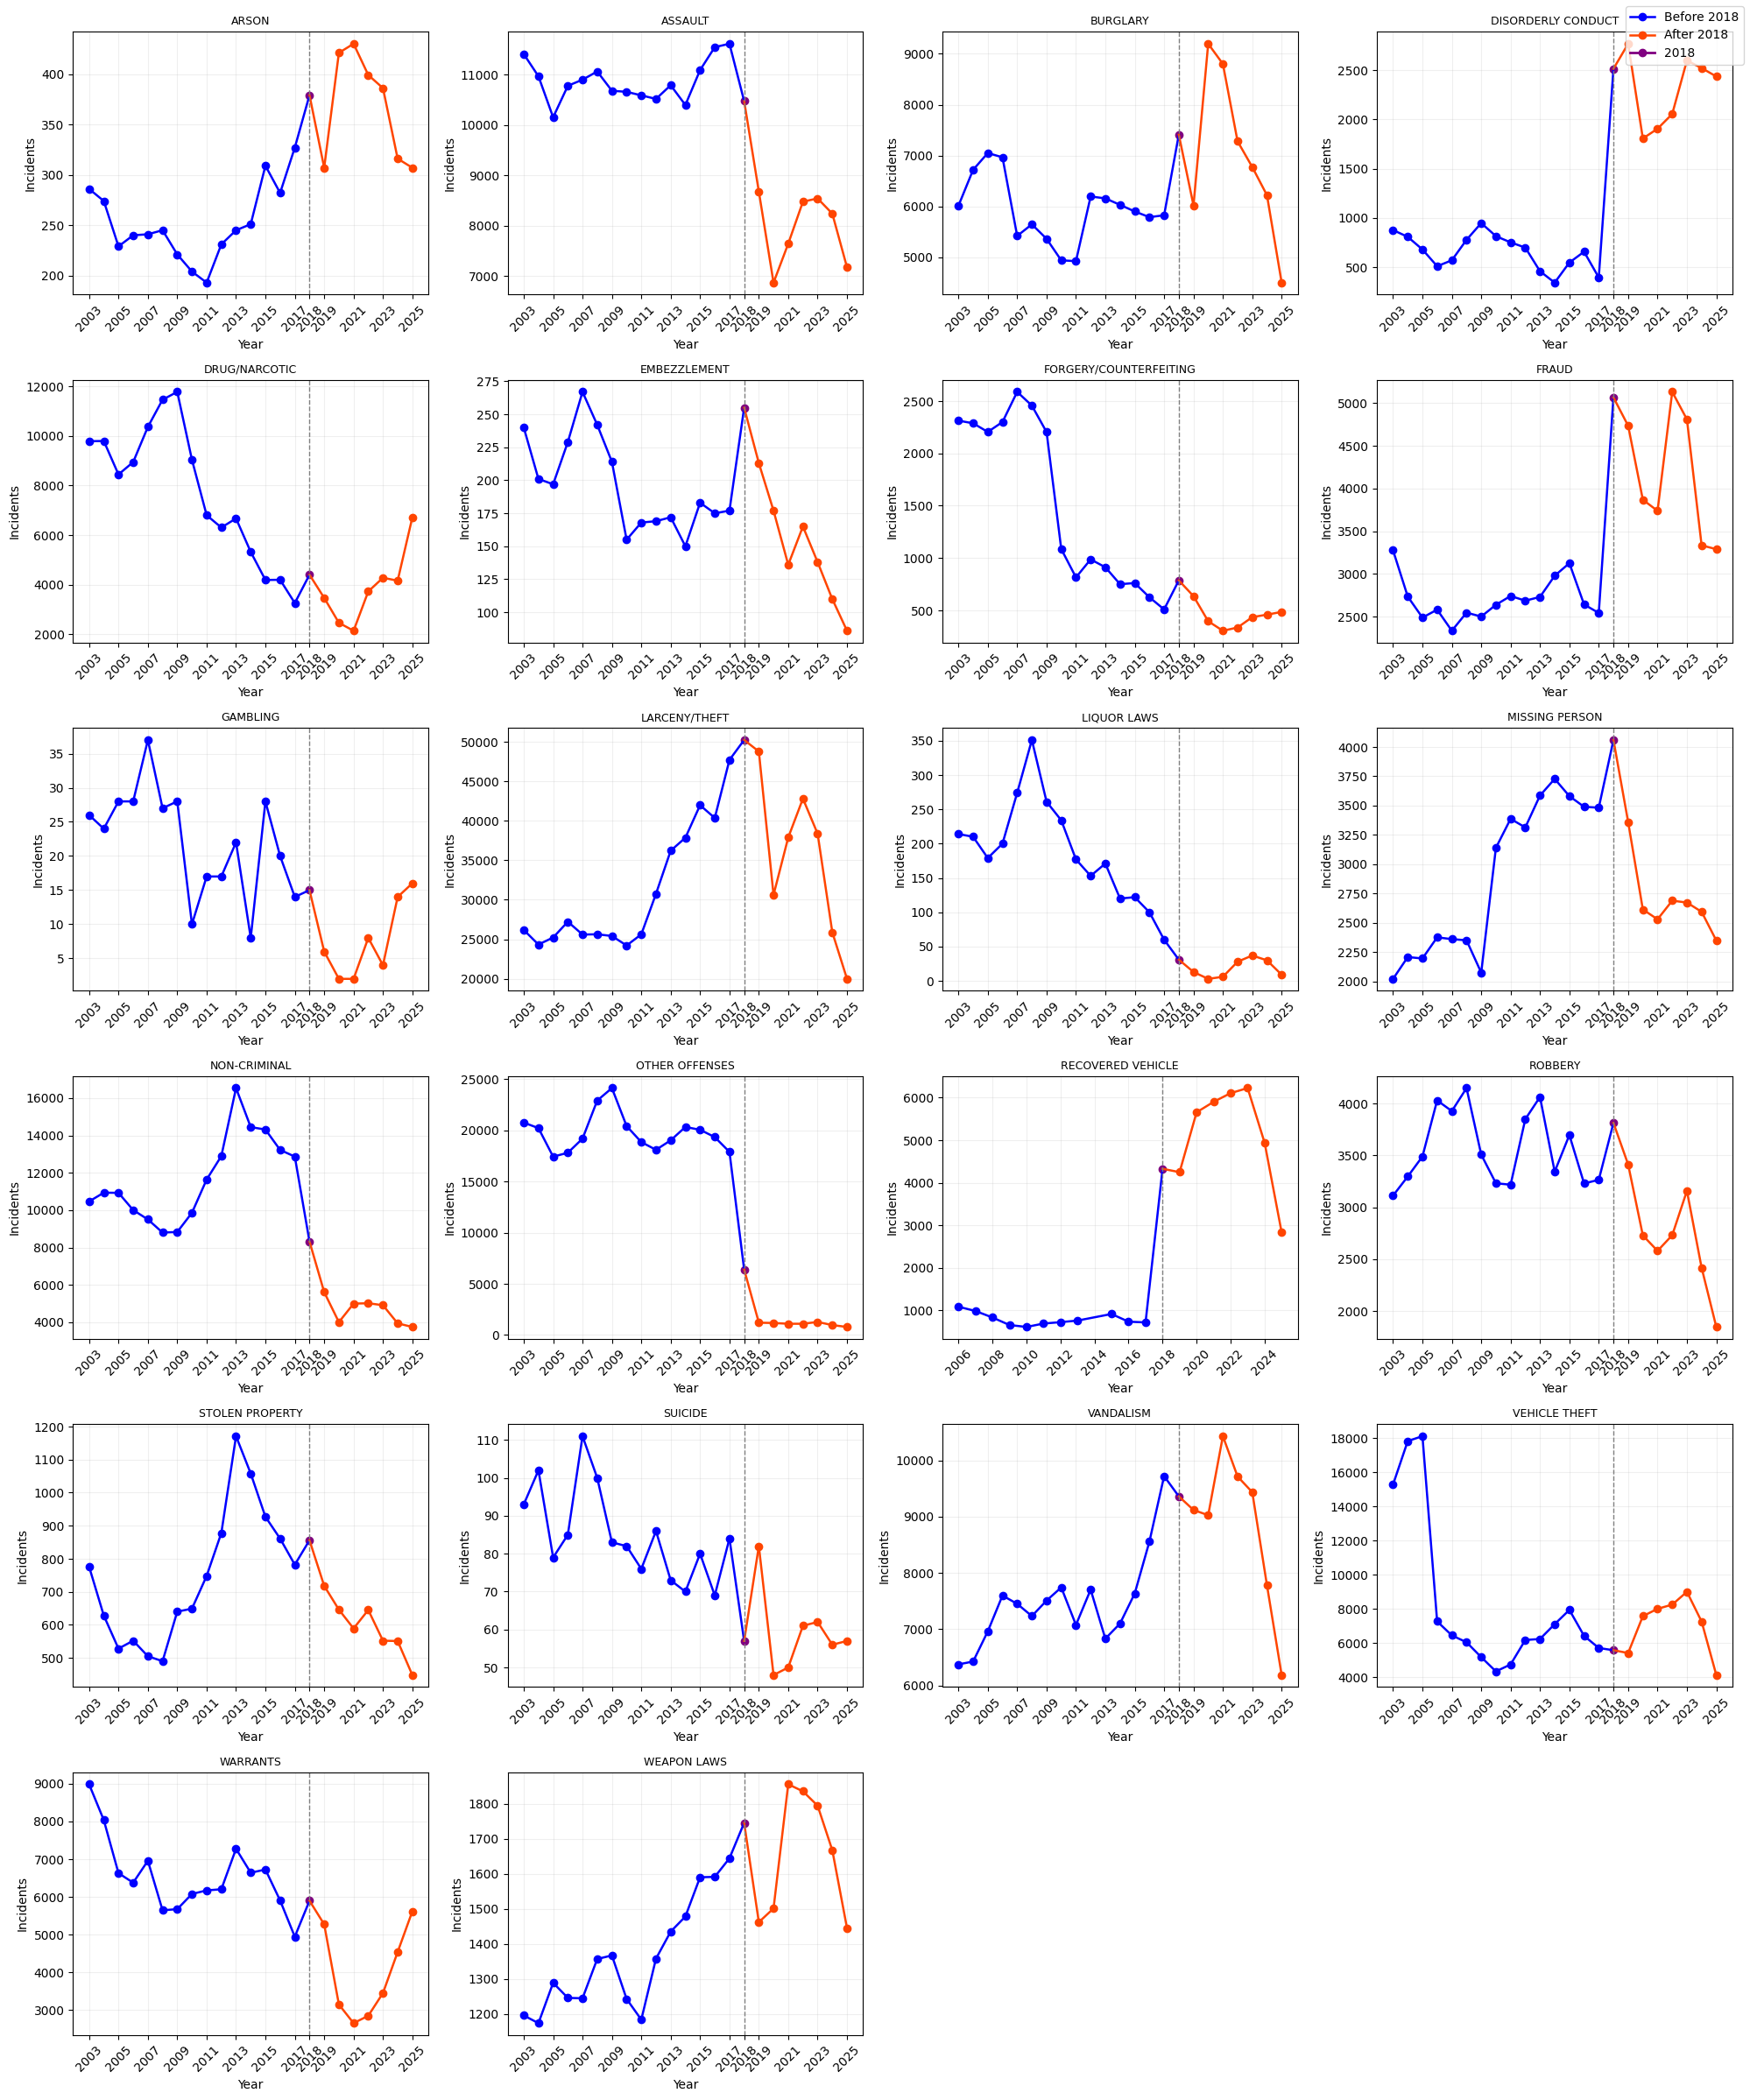

In [23]:
# Ensure datetime/year are ready
merged["datetime"] = pd.to_datetime(merged["datetime"], errors="coerce")
merged["year"] = merged["datetime"].dt.year

cats = sorted(merged["category"].dropna().unique())

n = len(cats)
ncols = 4
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 4 * nrows), sharex=False, sharey=False)
axes = np.array(axes).reshape(-1)

for i, cat in enumerate(cats):
    ax = axes[i]
    s = (
        merged.loc[merged["category"] == cat]
        .groupby("year")
        .size()
        .sort_index()
    )

    pre = s[s.index < 2018]
    y2018 = s[s.index == 2018]
    post = s[s.index > 2018]

    # Main segments
    if len(pre):
        ax.plot(pre.index, pre.values, color="blue", marker="o", linewidth=1.8, label="Before 2018")
    if len(post):
        ax.plot(post.index, post.values, color="orangered", marker="o", linewidth=1.8, label="After 2018")
    if len(y2018):
        ax.plot(y2018.index, y2018.values, color="purple", marker="o", linewidth=2.0, label="2018")

    # Connect 2017 -> 2018 (blue) and 2018 -> 2019 (orangered)
    if 2018 in s.index and 2017 in s.index:
        ax.plot([2017, 2018], [s.loc[2017], s.loc[2018]], color="blue", linewidth=1.8)
    if 2018 in s.index and 2019 in s.index:
        ax.plot([2018, 2019], [s.loc[2018], s.loc[2019]], color="orangered", linewidth=1.8)

    ax.axvline(2018, linestyle="--", color="gray", linewidth=1)
    ax.set_title(cat, fontsize=9)
    ax.set_xlabel("Year")
    ax.set_ylabel("Incidents")

    # Fewer x ticks to avoid overload
    x_min, x_max = int(s.index.min()), int(s.index.max())
    ticks = list(range(x_min, x_max + 1, 2))  # every 2 years
    if 2018 not in ticks and x_min <= 2018 <= x_max:
        ticks.append(2018)
        ticks = sorted(set(ticks))
    ax.set_xticks(ticks)
    ax.set_xticklabels([str(y) for y in ticks], rotation=45)

    ax.grid(alpha=0.2)

# Hide empty axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Single legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout()
plt.show()

### Final category decisions after visual trend validation

Based on the full evolutionary plots (pre-2018 vs post-2018), I define the final analytical set as follows.

#### Categories removed (final exclusion)

- **NON-CRIMINAL**  
  Too generic and shows a large structural shift after 2018.
- **DISORDERLY CONDUCT**  
  Too broad/ambiguous and non-comparable across periods.
- **OTHER OFFENSES**  
  Very generic residual class; low interpretability.
- **RECOVERED VEHICLE**  
  Better interpreted as incident/property recovery status than a crime type; strong comparability bias.
- **GAMBLING**  
  Very low counts and limited analytical relevance.
- **FRAUD**  
  Same label, but post-2018 behavior differs too much in level/shape for robust continuity.
- **ASSAULT**  
  High volume but notable level break after 2018; omitted to keep stricter comparability.
- **LIQUOR LAWS**  
  Relatively low volume and drops to very low levels post-2018.

#### Categories kept (final working set)

- **ARSON**
- **BURGLARY**
- **DRUG/NARCOTIC**
- **EMBEZZLEMENT**
- **FORGERY/COUNTERFEITING**
- **LARCENY/THEFT**
- **MISSING PERSON**
- **ROBBERY**
- **STOLEN PROPERTY**
- **SUICIDE** *(kept with caution due to low counts, but trend is relatively coherent and substantively interesting)*
- **VANDALISM**
- **VEHICLE THEFT**
- **WARRANTS**
- **WEAPON LAWS**

This gives a final set of **15 categories**, which stays within the target range (**8–16**) while prioritizing interpretability and cross-period comparability.


In [28]:
to_exclude = ["NON-CRIMINAL", "DISORDERLY CONDUCT", "OTHER OFFENSES", "RECOVERED VEHICLE", "GAMBLING", "FRAUD", "ASSAULT", "LIQUOR LAWS"]

merged = merged[
    ~merged["category"].isin(to_exclude)
].copy()

---

### ***Evolutionary bar plots for every Personal Focus Crime***

> #### *Draws from: Week 1, Exercise 4.2*

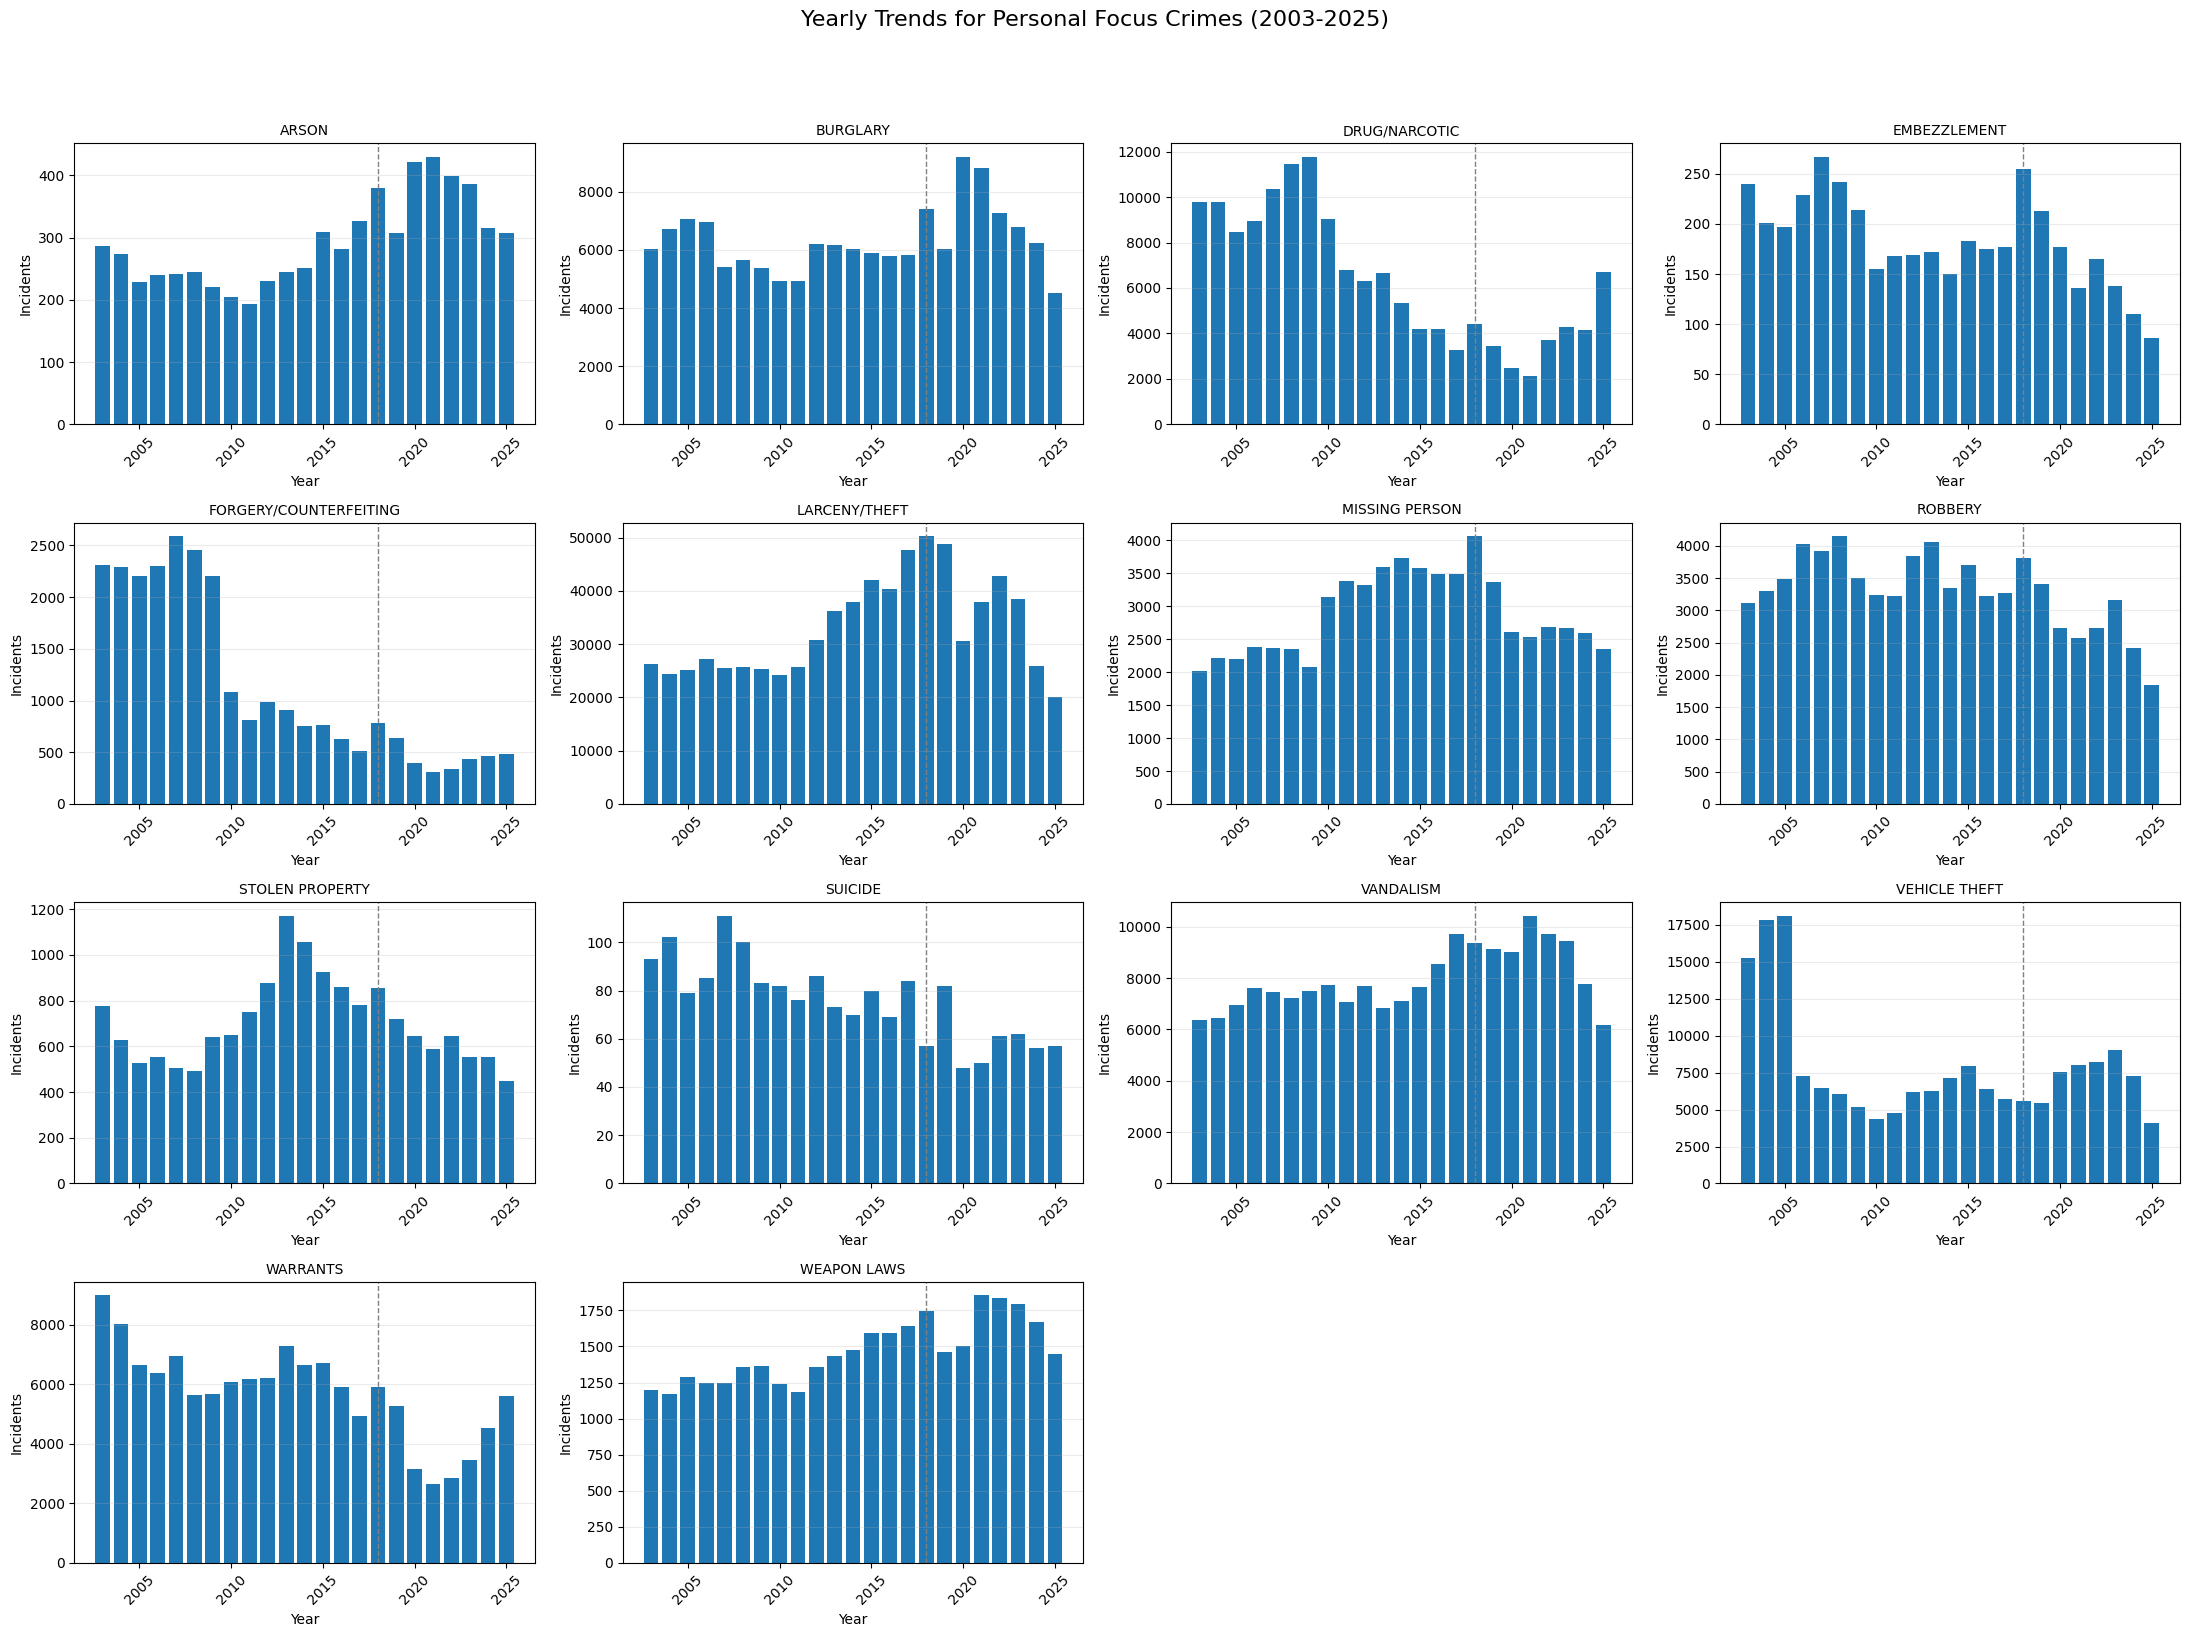

In [35]:
# Use merged dataset (2003-present) and category as Personal Focus Crime
df = merged.copy()

# Ensure year exists
if "year" not in df.columns:
    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
    df["year"] = df["datetime"].dt.year

# Keep requested window
year_min, year_max = 2003, 2025
years = pd.Index(range(year_min, year_max + 1), name="year")
df = df[df["year"].between(year_min, year_max)]

crimes = sorted(df["category"].dropna().unique())

# Subplots: 4 per row
n = len(crimes)
ncols = 4
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(22, 4 * nrows), sharex=False, sharey=False)
axes = np.array(axes).reshape(-1)

for i, crime in enumerate(crimes):
    ax = axes[i]
    s = (
        df.loc[df["category"] == crime]
        .groupby("year")
        .size()
        .reindex(years, fill_value=0)
    )

    # Barplot
    ax.bar(s.index, s.values, width=0.8)

    # Auxiliary line at 2018
    ax.axvline(2018, linestyle="--", color="gray", linewidth=1)

    ax.set_title(crime, fontsize=10)
    ax.set_ylabel("Incidents")
    ax.set_xlabel("Year")

    # X labels on every subplot (every 5 years)
    ticks = [y for y in range(year_min, year_max + 1) if y % 5 == 0]  # 2005, 2010, 2015, ...
    ticks = sorted(set(ticks))

    ax.set_xticks(ticks)
    ax.set_xticklabels([str(y) for y in ticks], rotation=45)

    ax.grid(axis="y", alpha=0.25)

# Hide empty panels
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Yearly Trends for Personal Focus Crimes (2003-2025)", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()
